# Fine-Tuning GPT-3.5-Turbo and LLaMA on Job Interview Data for Software Engineering

This notebook demonstrates the process of fine-tuning two advanced language models:
1. **GPT-3.5-Turbo-0125**
2. **LLaMA-3-8B-BNB-4BIT**


### Install dependencies and import required libraries

In [4]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.8 MB/s eta 0:00:00


In [5]:
!pip install sacrebleu rouge-score bert-score matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c03577d0a120d6eb01ea86d1a52c9e87f0850f7f47edb93acd3f8449e38ce241
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [6]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


In [11]:
import json
import tiktoken
import numpy as np
from collections import defaultdict
import openai
import base64
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import torch
from unsloth import FastLanguageModel
from datasets import Dataset
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from sklearn.model_selection import train_test_split
from trl import SFTTrainer
from transformers import TrainingArguments

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: OpenAI failed to import - ignoring for now.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Fine-Tuning **GPT-3.5-Turbo-0125**


---



### Dataset Loading and Exploration

In [26]:
data_path = "Software_Questions_GPT.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 50
First example:
{'role': 'system', 'content': 'You are an interviewer for software engineering job preparation. Ask questions, evaluate answers, and provide constructive feedback to help the candidate improve.'}
{'role': 'assistant', 'content': 'What is encapsulation in object-oriented programming?'}
{'role': 'user', 'content': 'It means hiding data from outside the class.'}
{'role': 'assistant', 'content': 'Good start! You correctly mentioned hiding data. To improve, include that encapsulation also bundles data and methods together into a single unit, like a class.'}


### Format validation

In [4]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


### Token Counting Utilities

In [5]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

### Data Warnings and Token Counts

In [6]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 4, 4
mean / median: 4.0, 4.0
p5 / p95: 4.0, 4.0

#### Distribution of num_total_tokens_per_example:
min / max: 84, 118
mean / median: 102.56, 102.5
p5 / p95: 94.0, 114.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 30, 60
mean / median: 46.62, 46.0
p5 / p95: 40.0, 54.2

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


### Cost Estimation

In [7]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~5128 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~15384 tokens


### Data Splitting and Preparation for the Fine-Tuned GPT-3.5 Model

In [27]:
# Split the data into training (80%) and test (20%) sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Save the training and test data as JSONL files
train_filename = '/content/train_data_GPT.jsonl'
test_filename = '/content/test_data_GPT.jsonl'

with open(train_filename, 'w') as train_file:
    for entry in train_data:
        train_file.write(json.dumps(entry) + '\n')

with open(test_filename, 'w') as test_file:
    for entry in test_data:
        test_file.write(json.dumps(entry) + '\n')

# Verify the split
print(f"Training data saved to: {train_filename}")
print(f"Test data saved to: {test_filename}")

Training data saved to: /content/train_data_GPT.jsonl
Test data saved to: /content/test_data_GPT.jsonl


### Uploading Data to the Fine-Tuned GPT-3.5 Model

In [1]:
import openai

# Set your API key
openai.api_key = "API_KEY"

# Upload a file
response = openai.File.create(
    file=open("train_data_GPT.jsonl", "rb"),
    purpose='fine-tune'
)
print(response)

response = openai.File.create(
    file=open("test_data_GPT.jsonl", "rb"),
    purpose='fine-tune'
)
print(response)


{
  "object": "file",
  "id": "file-8db9dmeWcm63GEehL2E5tk",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 25114,
  "created_at": 1734200377,
  "status": "processed",
  "status_details": null
}
{
  "object": "file",
  "id": "file-66J5ECbU2FQr6iNbXeBtiu",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 6369,
  "created_at": 1734200377,
  "status": "processed",
  "status_details": null
}


### Initiating Fine-Tuning Job for GPT-3.5-Turbo with **Auto Parameter**

In [4]:
response = openai.FineTuningJob.create(
training_file="file-6UZHp3fJ42p7wufjs8xz7Z",
validation_file="file-DgrhojF9KV9SSYY57XaLJU",
model="gpt-3.5-turbo-0125"
)

print("Fine-tuning job created:", response)

Fine-tuning job created: {
  "object": "fine_tuning.job",
  "id": "ftjob-YaSdWBCrwfXYaU8BlA2XMcFi",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1734200425,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-WRuovSAN4AZRX09Cj8z9c06I",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-DgrhojF9KV9SSYY57XaLJU",
  "training_file": "file-6UZHp3fJ42p7wufjs8xz7Z",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 2053073486,
  "estimated_finish": null,
  "integrations": []
}


### Monitor Progress of the Fine-Tuned GPT-3.5 Model

In [5]:
job_id = "ftjob-kww4GPkms44HfOGuUjxMBhZw"
response = openai.FineTuningJob.retrieve(job_id)
print(response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-kww4GPkms44HfOGuUjxMBhZw",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1733887050,
  "finished_at": 1733887402,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0125:personal::Ad7bnt1b",
  "organization_id": "org-WRuovSAN4AZRX09Cj8z9c06I",
  "result_files": [
    "file-XA182WmznE83phxB3oQhJE"
  ],
  "status": "succeeded",
  "validation_file": "file-DgrhojF9KV9SSYY57XaLJU",
  "training_file": "file-6UZHp3fJ42p7wufjs8xz7Z",
  "hyperparameters": {
    "n_epochs": 3,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": 12069,
  "error": {},
  "user_provided_suffix": null,
  "seed": 2052068139,
  "estimated_finish": null,
  "integrations": []
}


### Analyzing the Fine-Tuned GPT-3.5 Model

In [6]:
# Retrieve fine-tuning job events
events = openai.FineTuningJob.list_events(job_id)["data"]

for event in events:
    print(event["message"])

The job has successfully completed
New fine-tuned model created
Checkpoint created at step 80
Checkpoint created at step 40
Step 120/120: training loss=0.76, validation loss=0.93, full validation loss=1.02
Step 119/120: training loss=0.64
Step 118/120: training loss=0.81
Step 117/120: training loss=0.47
Step 116/120: training loss=0.78
Step 115/120: training loss=0.62
Step 114/120: training loss=0.42
Step 113/120: training loss=0.70
Step 112/120: training loss=0.55
Step 111/120: training loss=0.41
Step 110/120: training loss=0.73, validation loss=0.93
Step 109/120: training loss=0.39
Step 108/120: training loss=0.34
Step 107/120: training loss=0.58
Step 106/120: training loss=0.42
Step 105/120: training loss=0.68


In [7]:
# Find the last step (120/120)
last_step = None
for event in events:
    if event["type"] == "metrics" and event["data"]["step"] == 120:
        last_step = event
        break

if last_step:
    data = last_step["data"]
    print(f"Step: {data['step']}")
    print(f"Training Loss: {data['train_loss']:.4f}")
    print(f"Validation Loss: {data.get('valid_loss', 'Not Available')}")
    print(f"Full Validation Loss: {data.get('full_valid_loss', 'Not Available')}")
    print(f"Training Accuracy: {data['train_mean_token_accuracy']:.4%}")
    print(f"Validation Accuracy: {data.get('valid_mean_token_accuracy', 'Not Available')}")
    print(f"Full Validation Accuracy: {data.get('full_valid_mean_token_accuracy', 'Not Available')}")

Step: 120
Training Loss: 0.7567
Validation Loss: 0.9302433549551248
Full Validation Loss: 1.0215396510024015
Training Accuracy: 78.8462%
Validation Accuracy: 0.724038315341341
Full Validation Accuracy: 0.7101167315175098


In [8]:
# Retrieve fine-tuning job details and result file
fine_tune_results = openai.FineTuningJob.retrieve(job_id).get("result_files", [])
if not fine_tune_results:
    print("No result files found.")
else:
    result_file_id = fine_tune_results[0]
    result_file = openai.File.retrieve(result_file_id)
    content = openai.File.download(result_file_id)

    # Decode and save content as CSV
    decoded_content = base64.b64decode(content)
    file_path = "result.csv"
    with open(file_path, "wb") as f:
        f.write(decoded_content)

    print(f"Result file saved to {file_path}")

Result file saved to result.csv


In [9]:
# Load your result CSV file
file_path = "/content/result.csv"
data = pd.read_csv(file_path)

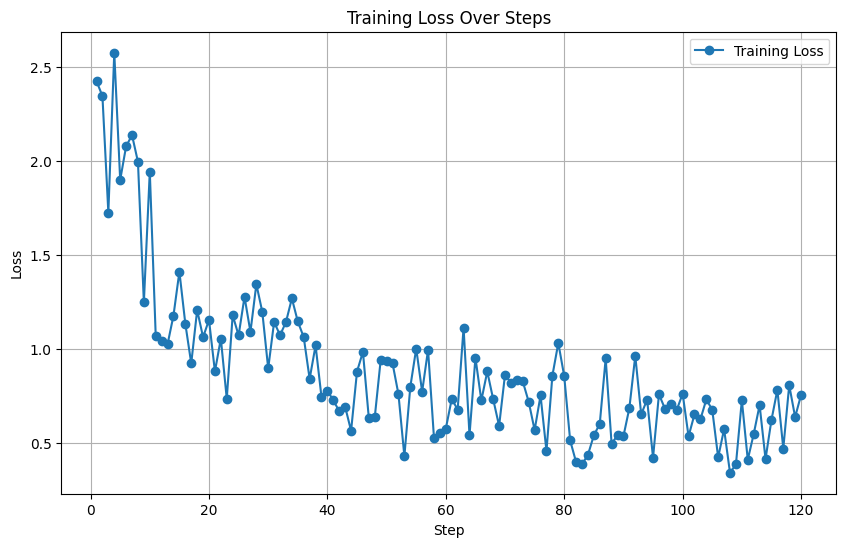

In [10]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['train_loss'], marker='o', label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

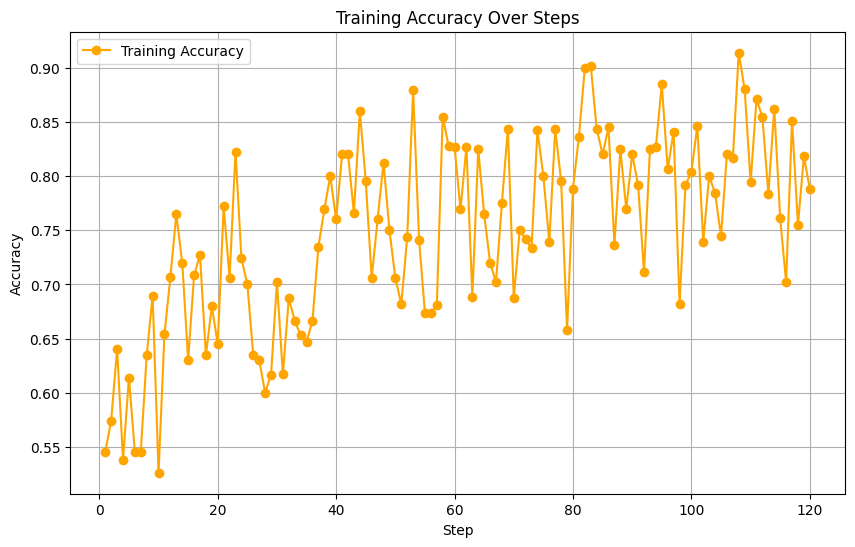

In [11]:
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['train_accuracy'], marker='o', label='Training Accuracy', color='orange')
plt.title('Training Accuracy Over Steps')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### Testing the Fine-Tuned GPT-3.5 Model
with auto prameter

In [12]:
completion = openai.ChatCompletion.create(
    model= "ft:gpt-3.5-turbo-0125:personal::Ad7bnt1b",
   messages=[
        {"role": "system", "content": "You are an interviewer for software engineering job preparation. Provide constructive feedback to help candidates improve."},
        {"role": "assistant", "content": "What is polymorphism in object-oriented programming?"},
        {"role": "user", "content": "It allows methods to do different things based on the object it is acting upon."}
    ]
)

# Print the model's feedback
print("Generated Feedback:")
print(completion["choices"][0]["message"]["content"])


Generated Feedback:
Great start! To enhance your answer, you can mention that polymorphism enables methods to be overridden in subclasses or to accept multiple types of parameters.


### Initiating Fine-Tuning Job for GPT-3.5-Turbo with **Additional Parameter**

### Monitor Progress of the Fine-Tuned GPT-3.5 Model

In [13]:
job_id = "ftjob-v01VYNmiWhF9GOQZtCJhjgnN"
response = openai.FineTuningJob.retrieve(job_id)
print(response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-v01VYNmiWhF9GOQZtCJhjgnN",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1734192767,
  "finished_at": 1734193863,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0125:personal::AePKiDcr",
  "organization_id": "org-WRuovSAN4AZRX09Cj8z9c06I",
  "result_files": [
    "file-PcomHxCKTS3mprNfy63LSM"
  ],
  "status": "succeeded",
  "validation_file": "file-DgrhojF9KV9SSYY57XaLJU",
  "training_file": "file-6UZHp3fJ42p7wufjs8xz7Z",
  "hyperparameters": {
    "n_epochs": 15,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": 60345,
  "error": {},
  "user_provided_suffix": null,
  "seed": 1046980418,
  "estimated_finish": null,
  "integrations": []
}


## Analyzing the Fine-Tuned GPT-3.5 Model

In [14]:
# Retrieve fine-tuning job events
events = openai.FineTuningJob.list_events(job_id)["data"]

for event in events:
    print(event["message"])

The job has successfully completed
New fine-tuned model created
Checkpoint created at step 560
Checkpoint created at step 520
Step 600/600: training loss=0.08, validation loss=1.39, full validation loss=1.92
Step 599/600: training loss=0.10
Step 598/600: training loss=0.08
Step 597/600: training loss=0.13
Step 596/600: training loss=0.10
Step 595/600: training loss=0.08
Step 594/600: training loss=0.08
Step 593/600: training loss=0.08
Step 592/600: training loss=0.10
Step 591/600: training loss=0.10
Step 590/600: training loss=0.10, validation loss=1.39
Step 589/600: training loss=0.09
Step 588/600: training loss=0.08
Step 587/600: training loss=0.08
Step 586/600: training loss=0.09
Step 585/600: training loss=0.07


In [15]:
# Find the last step (600/600)
last_step = None
for event in events:
    if event["type"] == "metrics" and event["data"]["step"] == 600:
        last_step = event
        break

# Display the last step metrics
if last_step:
    data = last_step["data"]
    print(f"Step: {data['step']}")
    print(f"Training Loss: {data['train_loss']:.4f}")
    print(f"Validation Loss: {data.get('valid_loss', 'Not Available')}")
    print(f"Full Validation Loss: {data.get('full_valid_loss', 'Not Available')}")
    print(f"Training Accuracy: {data['train_mean_token_accuracy']:.4%}")
    print(f"Validation Accuracy: {data.get('valid_mean_token_accuracy', 'Not Available')}")
    print(f"Full Validation Accuracy: {data.get('full_valid_mean_token_accuracy', 'Not Available')}")

Step: 600
Training Loss: 0.0756
Validation Loss: 1.3933859220594869
Full Validation Loss: 1.9182408848625212
Training Accuracy: 98.0392%
Validation Accuracy: 0.7297584687832296
Full Validation Accuracy: 0.6926070038910506


In [16]:
# Retrieve fine-tuning job details and result file
fine_tune_results = openai.FineTuningJob.retrieve(job_id).get("result_files", [])
if not fine_tune_results:
    print("No result files found.")
else:
    result_file_id = fine_tune_results[0]
    result_file = openai.File.retrieve(result_file_id)
    content = openai.File.download(result_file_id)

    # Decode and save content as CSV
    decoded_content = base64.b64decode(content)
    file_path = "result.csv"
    with open(file_path, "wb") as f:
        f.write(decoded_content)

    print(f"Result file saved to {file_path}")

Result file saved to result.csv


In [17]:
# Load your result CSV file
file_path = "/content/result.csv"
data = pd.read_csv(file_path)

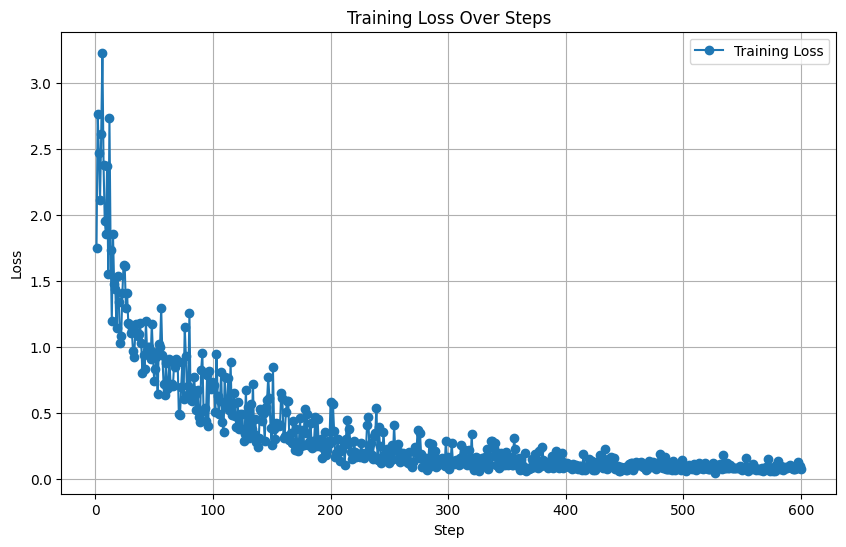

In [18]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['train_loss'], marker='o', label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

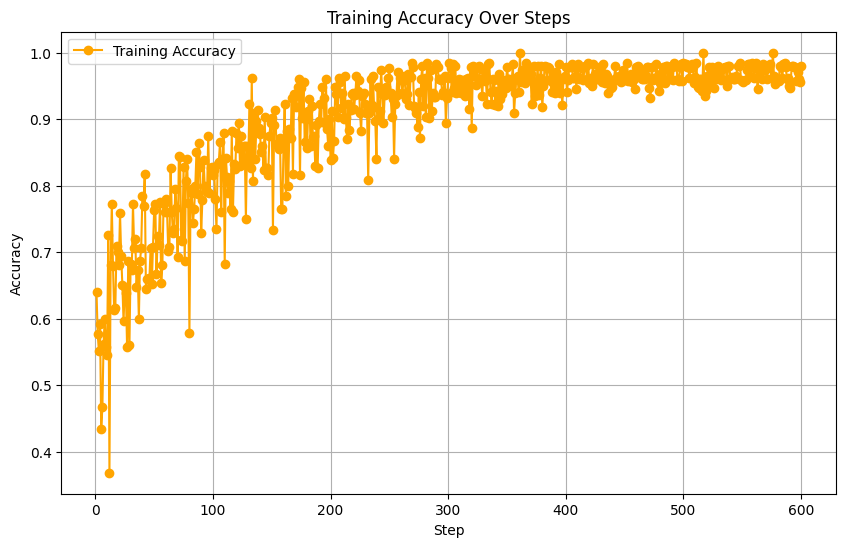

In [19]:
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['train_accuracy'], marker='o', label='Training Accuracy', color='orange')
plt.title('Training Accuracy Over Steps')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### Testing the Fine-Tuned GPT-3.5 Model
with additional prameter

In [20]:
completion = openai.ChatCompletion.create(
    model= "ft:gpt-3.5-turbo-0125:personal::AePKiDcr",
   messages=[
        {"role": "system", "content": "You are an interviewer for software engineering job preparation. Provide constructive feedback to help candidates improve."},
        {"role": "assistant", "content": "What is polymorphism in object-oriented programming?"},
        {"role": "user", "content": "It allows methods to do different things based on the object it is acting upon."}
    ]
)

# Print the model's feedback
print("Generated Feedback:")
print(completion["choices"][0]["message"]["content"])


Generated Feedback:
Great explanation! You correctly described polymorphism as enabling methods to behave differently based on the object. You could enhance your answer by mentioning its two types: compile-time (method overloading) and runtime (method overriding).


## Fine-Tuning **LLaMA-3-8B-BNB-4BIT**
Using `unsloth` and LoRA

---



### Setup Environment and Install Dependencies for LLaMA Fine-Tuning

In [8]:
%%capture
major_version, minor_version = torch.cuda.get_device_capability()
# Must install separately since Colab has torch 2.2.1, which breaks packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    # This for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    # This for older GPUs (V100, Tesla T4, RTX 20xx)
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

### Defining Configuration Parameters for LLaMA Fine-Tuning

In [2]:
# Define model configurations
model_name = "meta-llama/Llama-2-7b"
max_seq_length = 2048
dtype = None  # Automatically detect precision
lora_r = 8  # Rank of LoRA updates
lora_alpha = 32  # LoRA alpha parameter
lora_dropout = 0.1  # Dropout rate for LoRA


### Loading and Initializing the LLaMA Model with Configuration

In [12]:

# Initialize and load the model

dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

print("Model loaded successfully.")


==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Model loaded successfully.


### Applying PEFT (Parameter-Efficient Fine-Tuning) to LLaMA Model
using LoRA (Low-Rank Adaptation)

In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Loading and Preparing Dataset for LLaMA Fine-Tuning

In [15]:
data_path = "Software_Questions_LLaMA.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Split the data into training (80%) and test (20%) sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Save the training and test data as JSONL files
train_filename = '/content/train_data_LLaMA.jsonl'
test_filename = '/content/test_data_LLaMA.jsonl'

with open(train_filename, 'w') as train_file:
    for entry in train_data:
        train_file.write(json.dumps(entry) + '\n')

with open(test_filename, 'w') as test_file:
    for entry in test_data:
        test_file.write(json.dumps(entry) + '\n')

# Verify the split
print(f"Training data saved to: {train_filename}")
print(f"Test data saved to: {test_filename}")

Training data saved to: /content/train_data_LLaMA.jsonl
Test data saved to: /content/test_data_LLaMA.jsonl


### Formatting Dataset for LLaMA Fine-Tuning with Alpaca Prompt Style

In [16]:

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


# Load and process the training dataset
with open("/content/train_data_LLaMA.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]

train_dataset = Dataset.from_list(train_data)
formatted_train_dataset = train_dataset.map(formatting_prompts_func, batched=True)

# Load and process the testing dataset
with open("/content/test_data_LLaMA.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

test_dataset = Dataset.from_list(test_data)
formatted_test_dataset = test_dataset.map(formatting_prompts_func, batched=True)

# Display samples from formatted datasets
print("Sample from formatted train dataset:", formatted_train_dataset[0])
print("Sample from formatted test dataset:", formatted_test_dataset[0])


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Sample from formatted train dataset: {'instruction': 'You are an interviewer for software engineering job preparation. Ask questions, evaluate answers, and provide constructive feedback to help the candidate improve.', 'input': 'Mutable objects can change, while immutable objects cannot.', 'output': 'Correct! To expand, you could give examples like lists for mutable objects and tuples for immutable objects. Additionally, mention how immutability helps in thread safety.', 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an interviewer for software engineering job preparation. Ask questions, evaluate answers, and provide constructive feedback to help the candidate improve.\n\n### Input:\nMutable objects can change, while immutable objects cannot.\n\n### Response:\nCorrect! To expand, you could give examples like lists for mutable objects and t

### Training with LoRA Adapters for LLaMA Fine-Tuning with **Auto Parameter**

In [17]:

# Disable W&B integration
os.environ["WANDB_DISABLED"] = "true"

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=formatted_train_dataset,
    eval_dataset=formatted_test_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map (num_proc=2):   0%|          | 0/40 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/10 [00:00<?, ? examples/s]

### Training the LLaMA Model

In [18]:
# Train the model
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 40 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 15
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.907900
2,2.815200
3,2.876300
4,2.902500
5,2.823500
6,2.683800
7,2.523300
8,2.417800
9,2.290700
10,2.213000


TrainOutput(global_step=15, training_loss=2.430103651682536, metrics={'train_runtime': 101.7183, 'train_samples_per_second': 1.18, 'train_steps_per_second': 0.147, 'total_flos': 619628026626048.0, 'train_loss': 2.430103651682536, 'epoch': 3.0})

In [19]:
# Save the first trained model
trainer.save_model("first_trained_model")
tokenizer.save_pretrained("first_trained_model")

('first_trained_model/tokenizer_config.json',
 'first_trained_model/special_tokens_map.json',
 'first_trained_model/tokenizer.json')

###Evaluating the Fine-Tuned LLaMA Model

In [20]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 1.8926060199737549, 'eval_runtime': 4.1048, 'eval_samples_per_second': 2.436, 'eval_steps_per_second': 0.487, 'epoch': 3.0}


### Testing the Fine-Tuned LLaMA Model
with auto parameter

In [21]:
from unsloth import FastLanguageModel

# Load the first trained model
model1, tokenizer1 = FastLanguageModel.from_pretrained(
    model_name="first_trained_model",  # Directory where the first model was saved
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)
FastLanguageModel.for_inference(model1)  # Enable 2x faster inference

# Define the prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Prepare input for testing the first model
inputs1 = tokenizer1(
    [
        alpaca_prompt.format(
            "You are an interviewer for software engineering job preparation. Provide constructive feedback to help candidates improve.",  # instruction
            "polymorphism in object-oriented programming? It allows methods to do different things based on the object it is acting upon.",  # input
            "",  # output - leave blank for generation
        )
    ],
    return_tensors="pt",
).to("cuda")

# Generate response using the first model
outputs1 = model1.generate(**inputs1, max_new_tokens=64, use_cache=True)

# Decode and print response
response1 = tokenizer1.batch_decode(outputs1, skip_special_tokens=True)
print("Generated Feedback from First Model:")
print(response1[0].split("### Response:")[-1].strip())


==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Generated Feedback from First Model:
This response is correct. Polymorphism allows methods to do different things based on the object it is acting upon. It is a powerful feature of object-oriented programming that enables code reuse and flexibility.

### Feedback:
This response is correct. Polymorphism allows methods to do different things based on the object it is acting upon


### Training with LoRA Adapters for LLaMA Fine-Tuning with **Additional Parameter**

In [22]:

# Disable W&B integration
os.environ["WANDB_DISABLED"] = "true"
trainer2 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=formatted_train_dataset,
    eval_dataset=formatted_test_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        num_train_epochs= 15,
        learning_rate=2e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map (num_proc=2):   0%|          | 0/40 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/10 [00:00<?, ? examples/s]

### Training the LLaMA Model

In [23]:
# Train the model
trainer2.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 40 | Num Epochs = 15
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 75
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.897300
2,1.835700
3,1.760800
4,1.512200
5,1.284100
6,1.006000
7,0.856900
8,0.775700
9,0.762000
10,0.623400


TrainOutput(global_step=75, training_loss=0.2952285185456276, metrics={'train_runtime': 372.4243, 'train_samples_per_second': 1.611, 'train_steps_per_second': 0.201, 'total_flos': 3101762629632000.0, 'train_loss': 0.2952285185456276, 'epoch': 15.0})

In [24]:
# Save the first trained model
trainer2.save_model("second_trained_model")
tokenizer.save_pretrained("second_trained_model")

('second_trained_model/tokenizer_config.json',
 'second_trained_model/special_tokens_map.json',
 'second_trained_model/tokenizer.json')

###Evaluating the Fine-Tuned LLaMA Model

In [25]:
# Evaluate the model
results = trainer2.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 1.4123010635375977, 'eval_runtime': 1.4377, 'eval_samples_per_second': 6.956, 'eval_steps_per_second': 1.391, 'epoch': 15.0}


### Testing the Fine-Tuned LLaMA Model
with additional parameter

In [30]:
from unsloth import FastLanguageModel

# Load the second trained model
model1, tokenizer1 = FastLanguageModel.from_pretrained(
    model_name="second_trained_model",  # Directory where the first model was saved
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)
FastLanguageModel.for_inference(model1)  # Enable 2x faster inference

# Define the prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Prepare input for testing the first model
inputs1 = tokenizer1(
    [
        alpaca_prompt.format(
            "You are an interviewer for software engineering job preparation. Provide constructive feedback to help candidates improve.",  # instruction
            "polymorphism in object-oriented programming? It allows methods to do different things based on the object it is acting upon.",  # input
            "",  # output - leave blank for generation
        )
    ],
    return_tensors="pt",
).to("cuda")

# Generate response using the first model
outputs1 = model1.generate(**inputs1, max_new_tokens=64, use_cache=True)

# Decode and print response
response1 = tokenizer1.batch_decode(outputs1, skip_special_tokens=True)
print("Generated Feedback from First Model:")
print(response1[0].split("### Response:")[-1].strip())


Generated Feedback:
Nice explanation! You correctly mentioned polymorphism's ability to enable method invocation based on object type. For a complete answer, you could also add its role in code reuse and dynamic method invocation.


## Comparative Analysis


---



### Evaluating Model Performance with ROUGE and BERTScore Metrics

In [36]:
# Example predictions and reference
predictions = {
    "GPT Before Optimization": [
        "Great start! To enhance your answer, you can mention that polymorphism enables methods to be overridden in subclasses or to accept multiple types of parameters."
    ],
    "GPT After Optimization": [
        "Great explanation! You correctly described polymorphism as enabling methods to behave differently based on the object. You could enhance your answer by mentioning its two types: compile-time (method overloading) and runtime (method overriding)."
    ],
    "LLaMA Before Optimization": [
        "This response is correct. Polymorphism allows methods to do different things based on the object it is acting upon. It is a powerful feature of object-oriented programming that enables code reuse and flexibility."
    ],
    "LLaMA After Optimization": [
        "Nice explanation! You correctly mentioned polymorphism's ability to enable method invocation based on object type. For a complete answer, you could also add its role in code reuse and dynamic method invocation."
    ],
}
reference = [
    [
        "Polymorphism is a key concept in OOP, allowing methods to behave differently depending on the object. Include examples like draw() for Circle and Rectangle.",
        "Your explanation of polymorphism is a good start. Add examples of method overriding and overloading for clarity."
    ]
]




In [37]:
# Initialize metrics results
performance_metrics = {event: {} for event in predictions.keys()}


# Function to compute ROUGE
def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    results = {"rouge1": [], "rougeL": []}
    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref[0], pred)
        results["rouge1"].append(scores["rouge1"].fmeasure)
        results["rougeL"].append(scores["rougeL"].fmeasure)
    return {key: sum(values) / len(values) for key, values in results.items()}

# Function to compute BERTScore
def compute_bertscore(predictions, references):
    precision, recall, f1 = bert_score(predictions, [refs[0] for refs in references], lang="en")
    return {"precision": precision.mean().item(), "recall": recall.mean().item(), "f1": f1.mean().item()}


In [38]:
# Evaluate all events
for event, preds in predictions.items():
    performance_metrics[event].update(compute_rouge(preds, reference))
    performance_metrics[event].update(compute_bertscore(preds, reference))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [39]:
# Display Results
print("Performance Metrics:")
for event, metrics in performance_metrics.items():
    print(f"{event}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")
    print("\n")

Performance Metrics:
GPT Before Optimization:
  rouge1: 0.16326530612244897
  rougeL: 0.12244897959183673
  precision: 0.8590441942214966
  recall: 0.8646240234375
  f1: 0.8618250489234924


GPT After Optimization:
  rouge1: 0.31034482758620696
  rougeL: 0.31034482758620696
  precision: 0.859619140625
  recall: 0.8869781494140625
  f1: 0.8730843663215637


LLaMA Before Optimization:
  rouge1: 0.3793103448275862
  rougeL: 0.31034482758620696
  precision: 0.8911498785018921
  recall: 0.899871826171875
  f1: 0.8954895734786987


LLaMA After Optimization:
  rouge1: 0.3157894736842105
  rougeL: 0.2105263157894737
  precision: 0.8594263792037964
  recall: 0.8736572265625
  f1: 0.8664833903312683




### Comparing GPT Performance Before and After Optimization Using Metrics

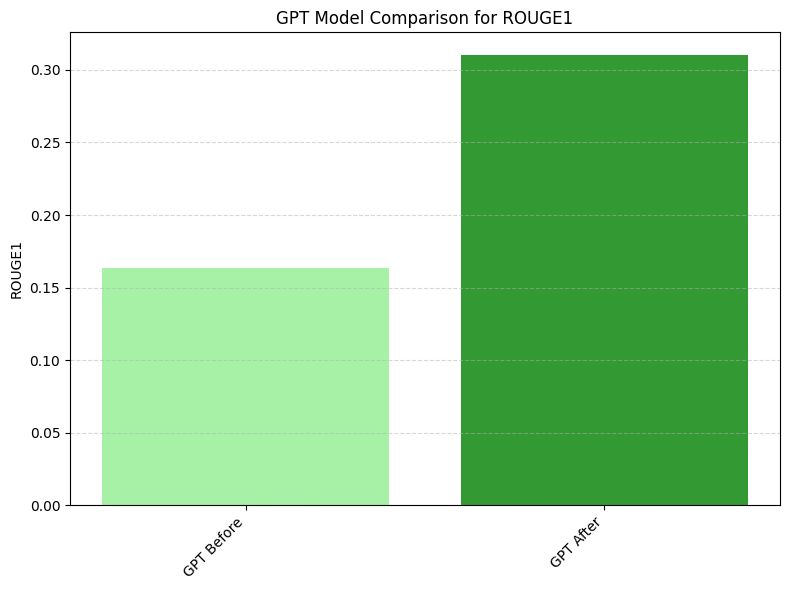

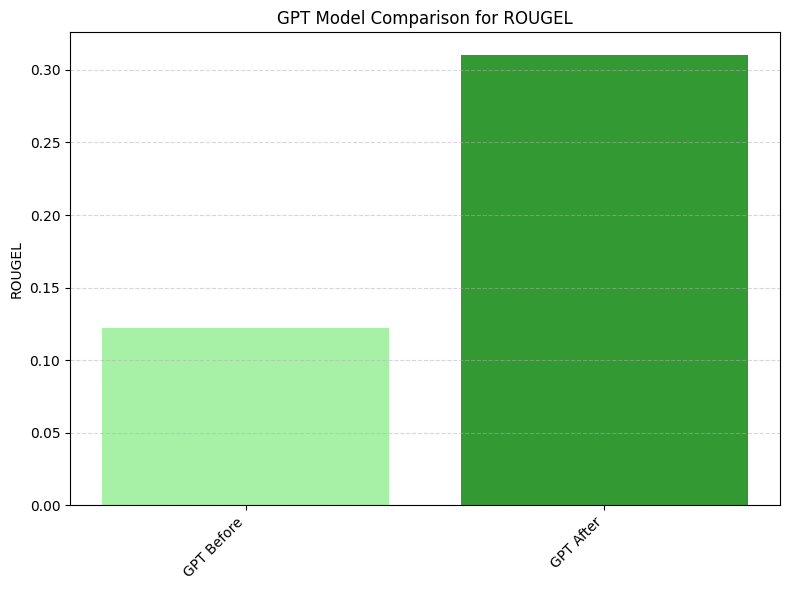

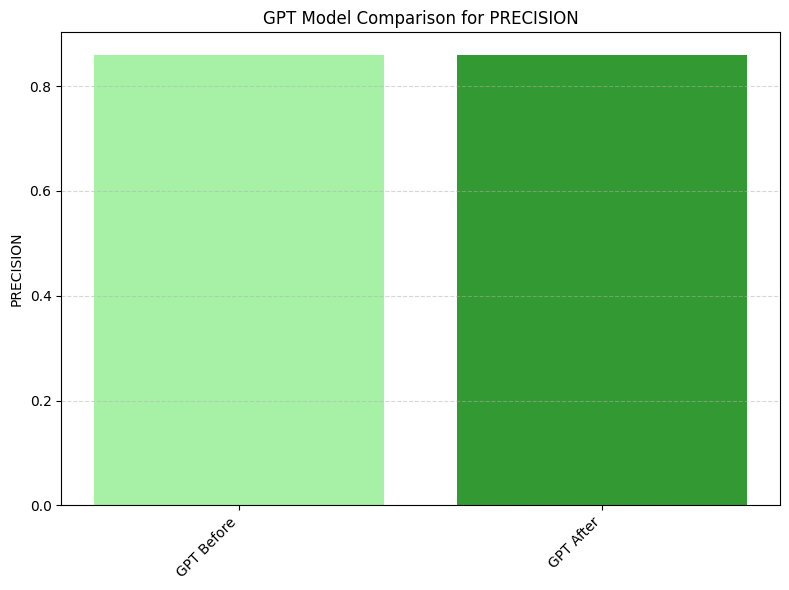

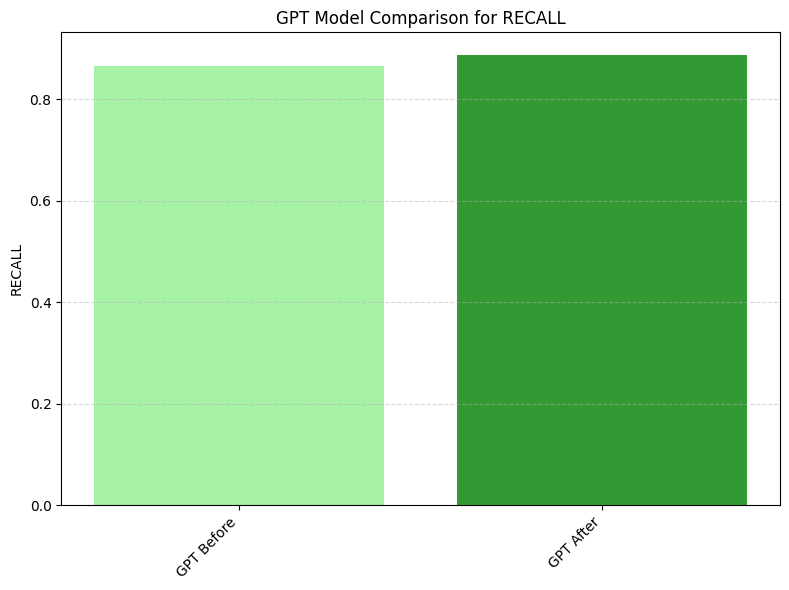

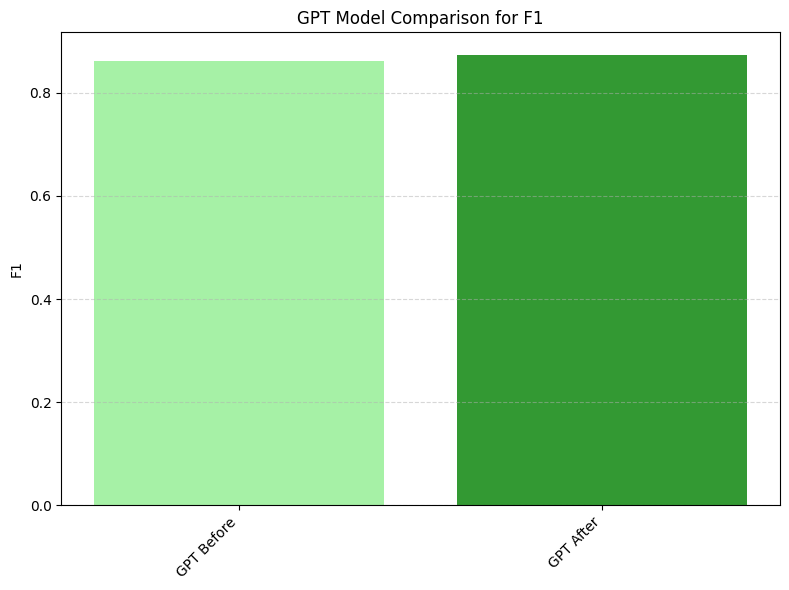

In [40]:
# Comparison 1: GPT Before vs After Optimization
metrics = ["rouge1", "rougeL", "precision", "recall", "f1"]

for metric in metrics:
    values = [
        performance_metrics["GPT Before Optimization"].get(metric, None),
        performance_metrics["GPT After Optimization"].get(metric, None),
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(
        ["GPT Before", "GPT After"],
        values,
        color=["lightgreen", "green"],  # Colors for GPT Before and After
        alpha=0.8,
    )
    plt.title(f"GPT Model Comparison for {metric.upper()}")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

### Comparing LLaMA Performance Before and After Optimization Using Metrics

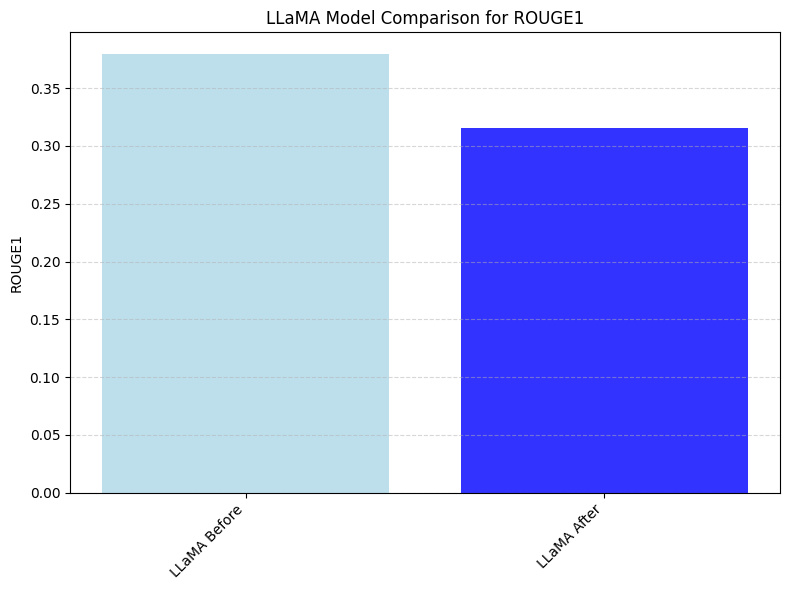

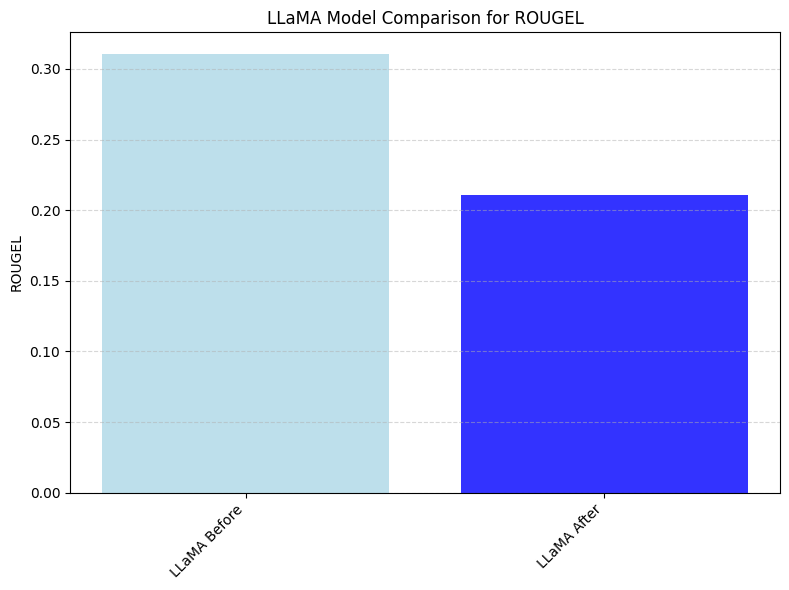

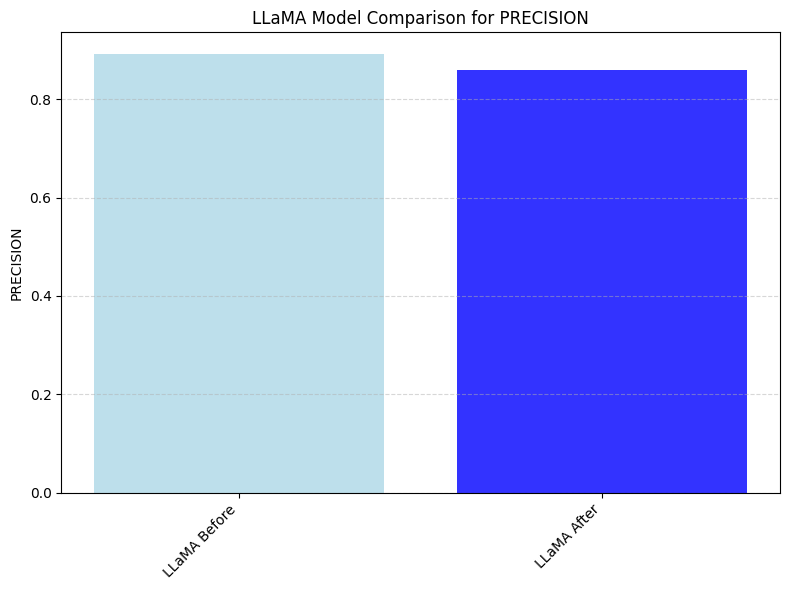

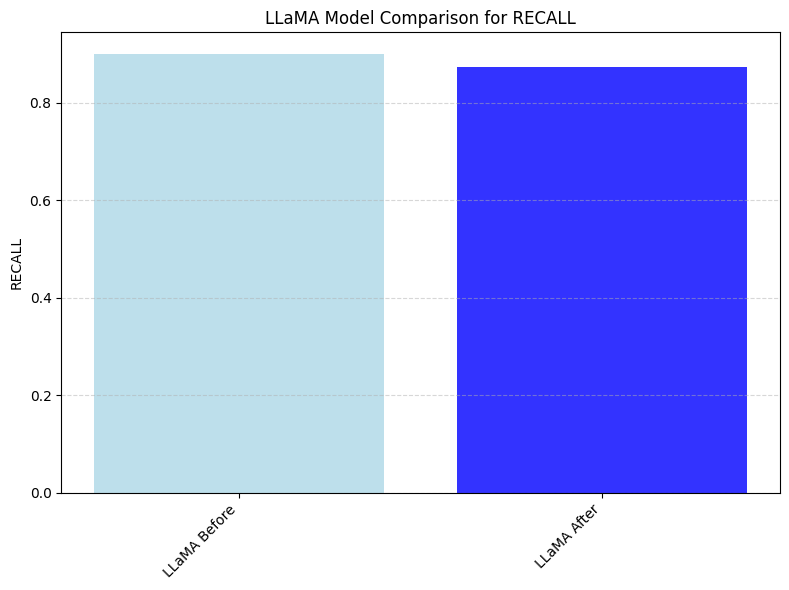

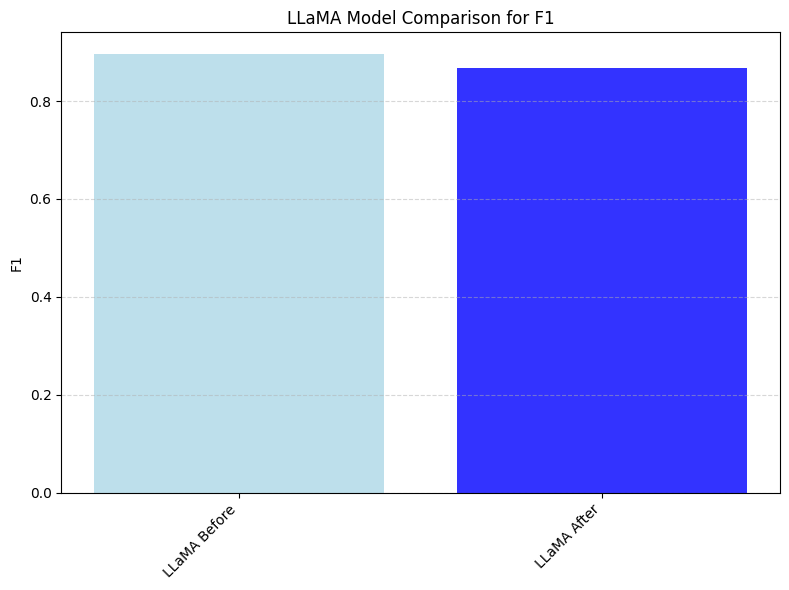

In [41]:
# Comparison 2: LLaMA Before vs After Optimization
metrics = ["rouge1", "rougeL", "precision", "recall", "f1"]

for metric in metrics:
    values = [
        performance_metrics["LLaMA Before Optimization"].get(metric, None),
        performance_metrics["LLaMA After Optimization"].get(metric, None),
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(
        ["LLaMA Before", "LLaMA After"],
        values,
        color=["lightblue", "blue"],  # Colors for LLaMA Before and After
        alpha=0.8,
    )
    plt.title(f"LLaMA Model Comparison for {metric.upper()}")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

### Comparison of GPT and LLaMA Performance Before Optimization Using Metrics

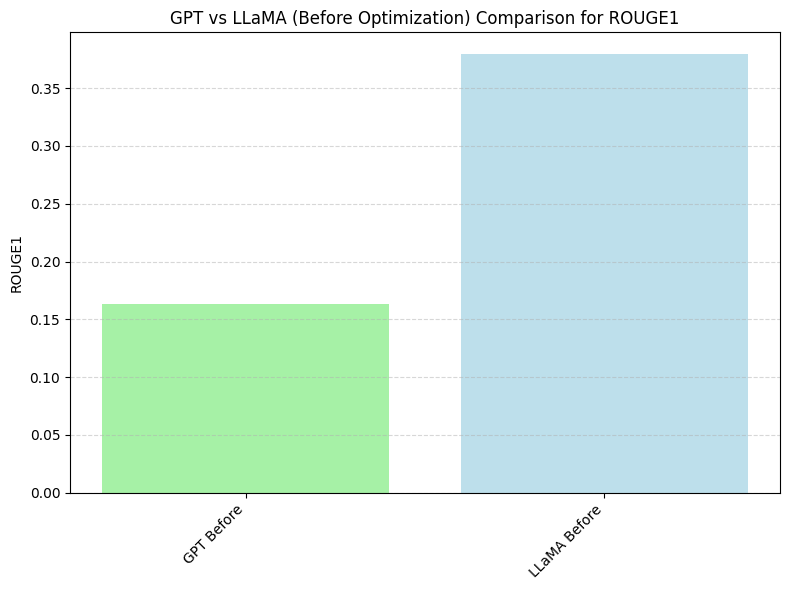

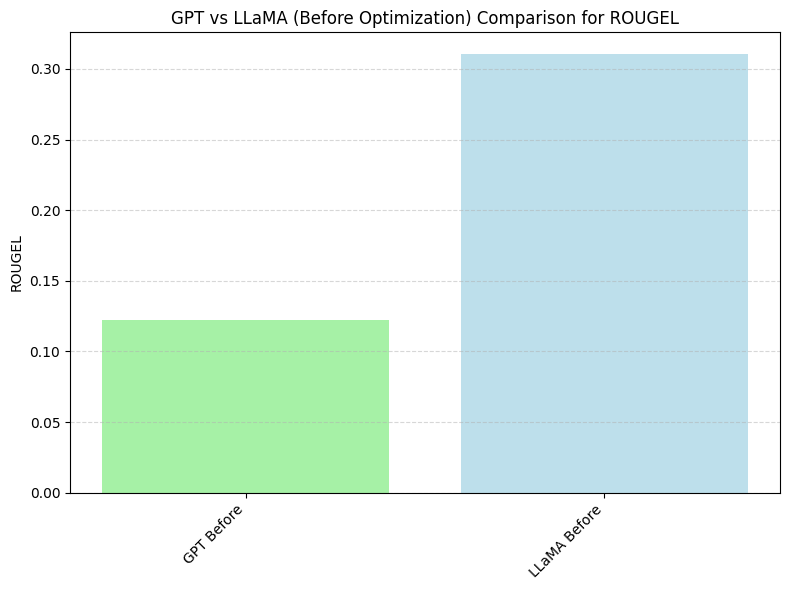

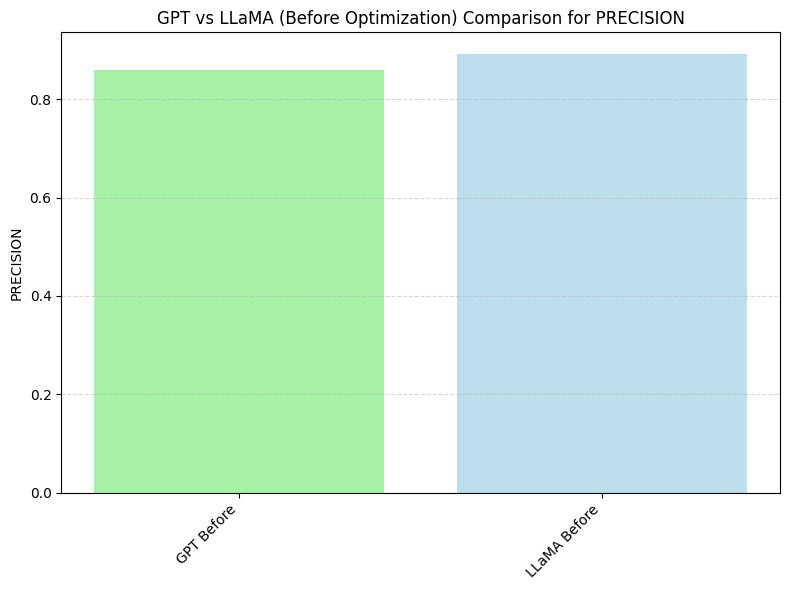

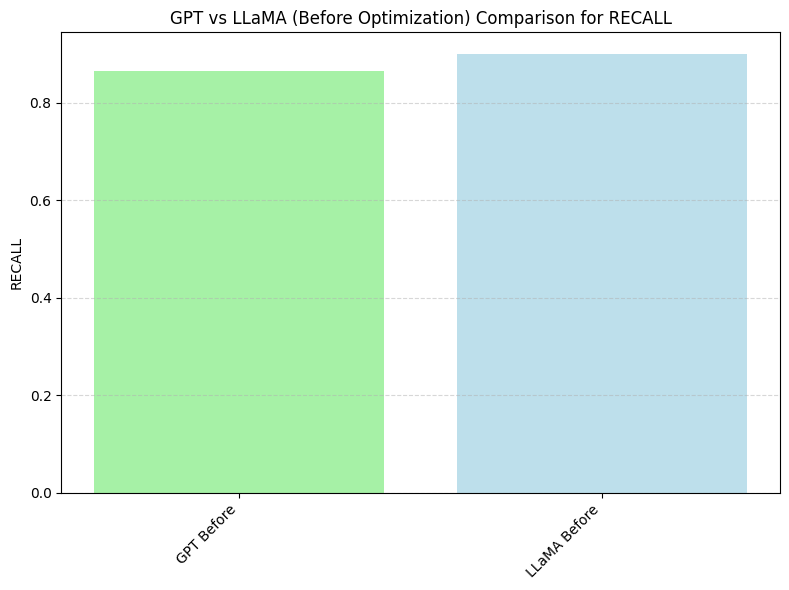

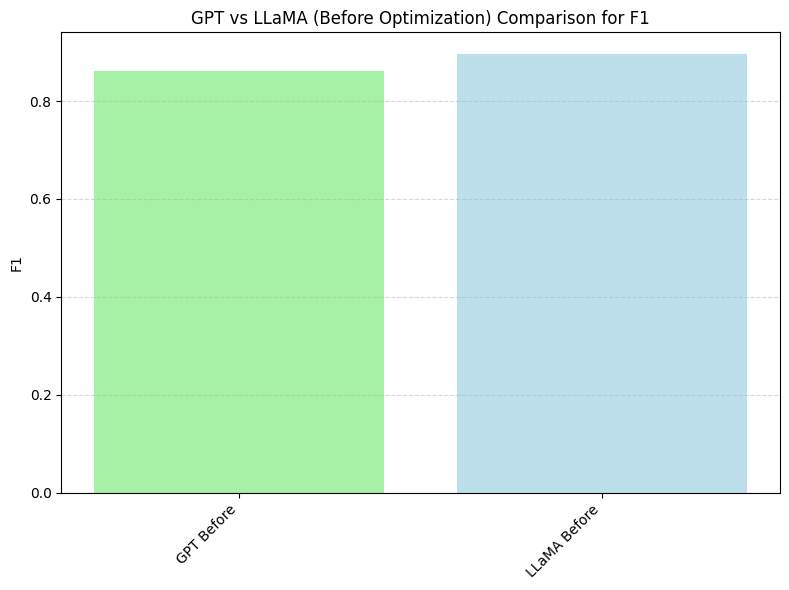

In [42]:
# Comparison 3: GPT vs LLaMA Before Optimization
metrics = ["rouge1", "rougeL", "precision", "recall", "f1"]

for metric in metrics:
    values = [
        performance_metrics["GPT Before Optimization"].get(metric, None),
        performance_metrics["LLaMA Before Optimization"].get(metric, None),
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(
        ["GPT Before", "LLaMA Before"],
        values,
        color=["lightgreen", "lightblue"],  # Colors for GPT Before and LLaMA Before
        alpha=0.8,
    )
    plt.title(f"GPT vs LLaMA (Before Optimization) Comparison for {metric.upper()}")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


### Comparison of GPT and LLaMA Performance After Optimization Using Metrics

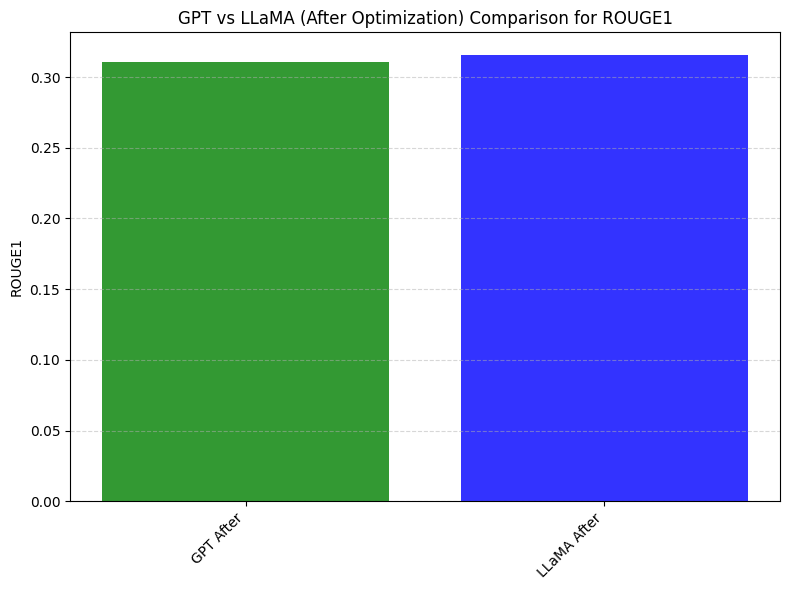

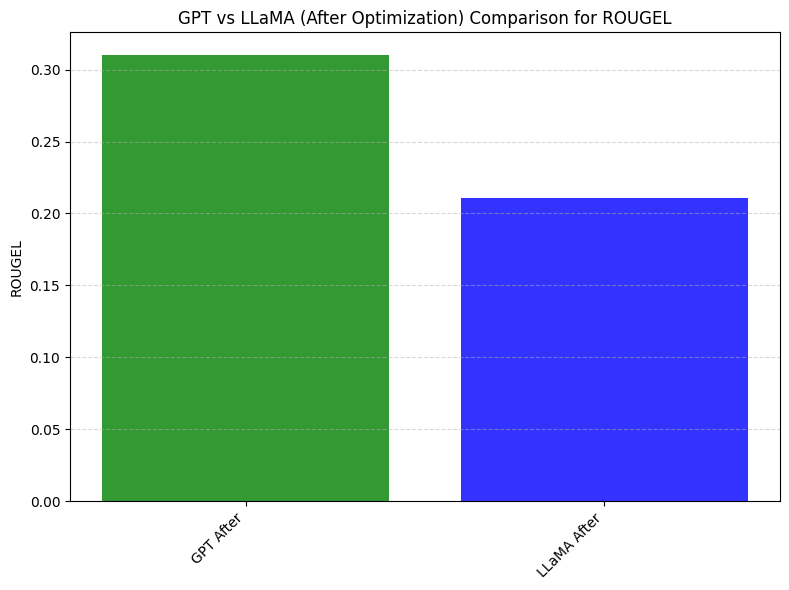

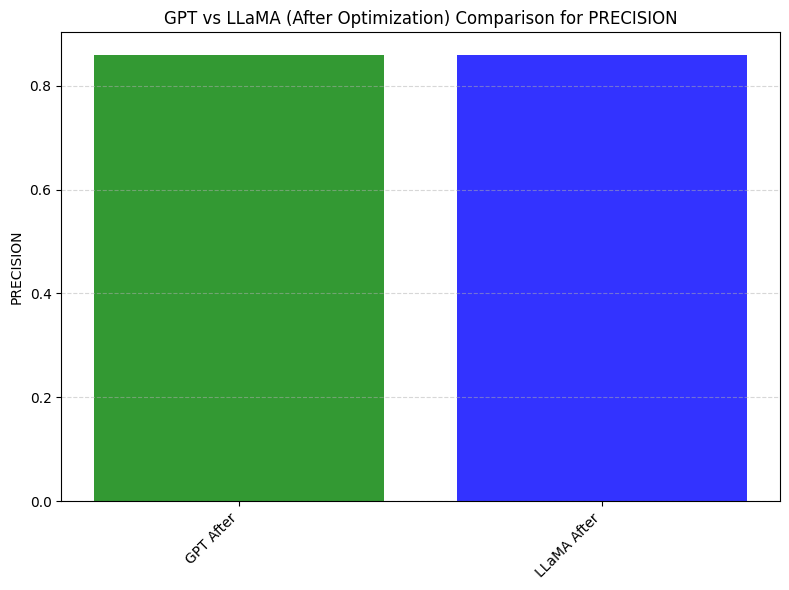

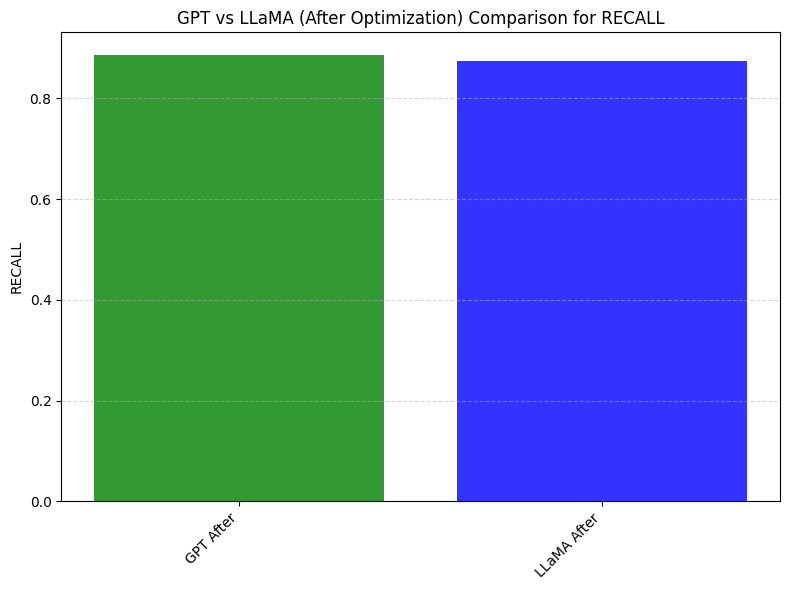

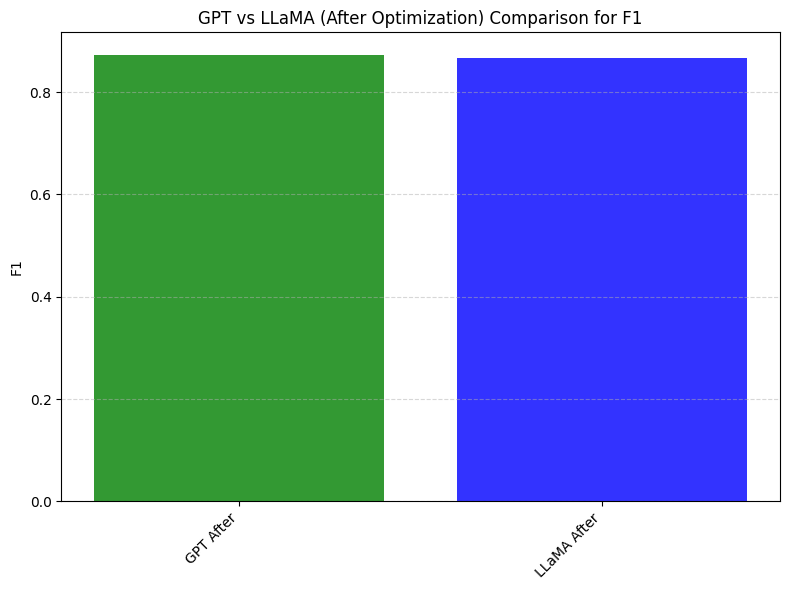

In [43]:
# Comparison 4: GPT vs LLaMA After Optimization
metrics = ["rouge1", "rougeL", "precision", "recall", "f1"]

for metric in metrics:
    values = [
        performance_metrics["GPT After Optimization"].get(metric, None),
        performance_metrics["LLaMA After Optimization"].get(metric, None),
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(
        ["GPT After", "LLaMA After"],
        values,
        color=["green", "blue"],  # Colors for GPT After and LLaMA After
        alpha=0.8,
    )
    plt.title(f"GPT vs LLaMA (After Optimization) Comparison for {metric.upper()}")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()